# 📌 Proyecto de Preprocesamiento

Este proyecto se divide en 2 etapas:
**- Etapa 1** = Pasos 1 al 4 donde se aprende de manera manual a realizar el preprocesamiento (carga de datos, limpieza, codificación, escalamiento) paso a paso utilizando Pandas, Numpy.
**- Etapa 2** = Pasos 5 al 7 donde se realiza el preprocesamiento de manera automatizada con pipelines, empaquetando todo lo realizado en los pasos 1 - 4 con SciKit Learn.

### **Paso 1:** Conexión a MongoDB y carga de datos

Acá realizamos la conexión a la base de datos en MongoDB y cargamos los datos en un Data Frame de Pandas.

In [1]:
from pymongo import MongoClient
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Conectarse al servidor local de MongoDB (ajustar si usas otro host o puerto)
conexion = MongoClient("mongodb://localhost:27017/")

# Seleccionar base de datos y colección
bd = conexion["becas_chile"]
coleccion = bd["postulantes_becas"]

# Obtener los datos y convertirlos a DataFrame
# .find(): ejecuta una consulta a MongoDB, equivalente a un "SELECT *" en SQL.
# - Primer argumento {}: es el filtro de búsqueda. En este caso está vacío ({}), lo que significa que selecciona todos los documentos sin filtrar nada.
datos = list(coleccion.find({}))
df = pd.DataFrame(datos)
df = df.drop(columns=["_id"])

# Mostrar primeras filas del DataFrame
df.head()

,nombre,sexo,edad,comuna,tipo_colegio,puntaje_paes,promedio_notas,ingreso_familiar,postula_a_beca
0,Camila Torres,F,18,La Florida,subvencionado,765,6.1,480000,True
1,Ignacio Paredes,M,19,Puente Alto,municipal,620,5.4,300000,True
2,Valentina Rojas,F,18,Vitacura,particular,845,6.8,1250000,False
3,Matías Herrera,M,17,Maipú,municipal,580,5.1,260000,True
4,Daniela González,F,19,Ñuñoa,particular,799,6.5,890000,False


In [ ]:
# Tamaño del dataset
print(f"Cantidad de registros: {df.shape[0]}")
print(f"Cantidad de columnas: {df.shape[1]}")

In [ ]:
# Tipos de datos
print("\nTipos de datos:")
print(df.dtypes)

In [ ]:
# Valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())

### **Paso 2:** Limpieza y tratamiento general

En este paso revisaremos la calidad de los datos:
- Verificaremos si hay registros duplicados
- Trataremos valores nulos
- Exploraremos posibles valores atípicos (outliers)

In [ ]:
# Verificamos si hay duplicados exactos
duplicados = df.duplicated().sum()
print(f"Registros duplicados encontrados: {duplicados}")

# Si hay, los eliminamos
df = df.drop_duplicates()

In [ ]:
# Volvemos a revisar si hay valores nulos por columna
print("Valores nulos por columna:")
print(df.isnull().sum())

# En este dataset simulado, no deberían haber nulos. Pero si los hubiera:
# df['ingreso_familiar'] = df['ingreso_familiar'].fillna(df['ingreso_familiar'].median())
# df['promedio_notas'] = df['promedio_notas'].fillna(df['promedio_notas'].mean())

In [ ]:
# Podemos ver algunos valores extremos visualmente
# Aquí buscamos valores muy bajos o muy altos, por ejemplo ingresos fuera de rango o notas fuera del sistema chileno (1.0 - 7.0).
df.describe()

### **Paso 3:** Codificación de variables categóricas

Los modelos de Machine Learning trabajan con números, no con texto.
Por eso, debemos transformar las variables categóricas en variables numéricas.

En este dataset tenemos principalmente tres variables categóricas:
- `sexo` → Binaria (M / F)
- `tipo_colegio` → Nominal (municipal / subvencionado / particular)
- `comuna` → Nominal con múltiples categorías

Para codificarlas usaremos:
- Variables dummy (binarias) para `sexo` y `tipo_colegio`
- One-Hot Encoding para `comuna`

In [ ]:
# Seleccionamos las columnas categóricas (tipo object o string)
columnas_categoricas = df.select_dtypes(include=["object"]).columns
print("Columnas categóricas detectadas:", list(columnas_categoricas))

In [ ]:
# Creamos una columna binaria: M = 1, F = 0
df["sexo"] = df["sexo"].map({"M": 1, "F": 0})
df.head()

In [ ]:
# Codificar tipo_colegio y comuna usando One-Hot Encoding
df = pd.get_dummies(df, columns=["tipo_colegio", "comuna"], drop_first=True)
df.head()

Ahora el DataFrame solo tiene variables numéricas, listas para el paso 4 (Escalamiento de variables numéricas).

Ventajas:
- Los modelos de ML ya pueden interpretar la información
- Evitamos errores por categorías de texto
- El escalamiento en el siguiente paso solo se aplicará a las variables numéricas que lo necesiten

Pero antes:
- Verifiquemos que tras la codificación todas las columnas son numéricas y no quedó ninguna categórica sin transformar.
- Todas las columnas deberían ser int64 o float64.
- No debería quedar ninguna columna tipo object (texto).
- Los nombres de columnas nuevas seguirán el formato tipo_colegio_xxx o comuna_xxx.

In [ ]:
# Lista final de columnas después de la codificación
print("Columnas finales del DataFrame:")
print(list(df.columns))

In [ ]:
# Verificar tipos de datos
print("\nTipos de datos después de la codificación:")
print(df.dtypes.value_counts())

In [ ]:
# Mostrar primeras filas para inspección
df.head()

### **Paso 4:** Escalamiento de variables numéricas

El escalamiento permite que todas las variables numéricas estén en un rango comparable.

En este caso aplicaremos:
- **Min-Max Scaling** para llevar los valores a un rango entre 0 y 1.
- **Estandarización (Z-Score)** para tener media 0 y desviación estándar 1.

Según el algoritmo de ML que usemos, elegiremos una u otra.
Por ejemplo:
- KNN, K-Means → necesitan escalamiento
- Modelos basados en árboles (Random Forest, XGBoost) → no lo necesitan

In [ ]:
# Identificar columnas numéricas a escalar

# Seleccionar columnas numéricas (excluyendo la variable objetivo si existe)
columnas_numericas = df.select_dtypes(include=["int64", "float64"]).columns
print("Columnas numéricas detectadas:", list(columnas_numericas))

In [ ]:
# Aplicar Min-Max Scaling

# Creamos una copia para no sobreescribir df original
df_minmax = df.copy()

# Escalador Min-Max
minmax_scaler = MinMaxScaler()
df_minmax[columnas_numericas] = minmax_scaler.fit_transform(df_minmax[columnas_numericas])

print("DataFrame con Min-Max Scaling:")
df_minmax.head()

In [ ]:
# Aplicar Estandarización (Z-Score)

# Creamos una copia para no sobreescribir df original
df_standard = df.copy()

# Escalador Standard
standard_scaler = StandardScaler()
df_standard[columnas_numericas] = standard_scaler.fit_transform(df_standard[columnas_numericas])

print("DataFrame con Estandarización (Z-Score):")
df_standard.head()

- Solo escalamos **variables numéricas**.
- Variables dummy o One-Hot Encoding **no deben escalarse** porque perderían su sentido.
- El escalador se debe ajustar (`fit`) **solo con los datos de entrenamiento** y luego aplicar (`transform`) a entrenamiento y prueba para evitar *data leakage*.

Para aprender **¿qué pasó con la columna edad?**

### **Paso 5:** Preprocesamiento de datos enfocados en Machine Learning

Acá vamos a encapsular TODAS las transformaciones de datos (imputación, codificación, escalamiento) en un flujo reproducible y seguro contra *data leakage*.

**Idea clave:** diseñamos un `preprocessor` que:
- Para columnas **numéricas**: imputa faltantes con MEDIANA y estandariza (media=0, std=1).
- Para columnas **categóricas**: imputa faltantes con la categoría más frecuente y hace One-Hot Encoding (eliminando la primera categoría para evitar multicolinealidad en modelos lineales).

**Importante:** en este paso **NO ajustamos** (`fit`) el pipeline. El ajuste ocurre en el **Paso 6**, *solo con el set de entrenamiento*.

In [2]:
# Librerías necesarias para construir un pipeline
import pandas as pd
from pymongo import MongoClient

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [3]:
# Importación de datos nuevamente para trabajar con ellos en crudo
cliente = MongoClient("mongodb://localhost:27017/")
basedatos = cliente["becas_chile"]
coleccion = basedatos["postulantes_becas"]

datos_raw = list(coleccion.find({}))
df_raw = pd.DataFrame(datos_raw)
df_raw = df_raw.drop(columns=["_id"])
df_raw.head()

,nombre,sexo,edad,comuna,tipo_colegio,puntaje_paes,promedio_notas,ingreso_familiar,postula_a_beca
0,Camila Torres,F,18,La Florida,subvencionado,765,6.1,480000,True
1,Ignacio Paredes,M,19,Puente Alto,municipal,620,5.4,300000,True
2,Valentina Rojas,F,18,Vitacura,particular,845,6.8,1250000,False
3,Matías Herrera,M,17,Maipú,municipal,580,5.1,260000,True
4,Daniela González,F,19,Ñuñoa,particular,799,6.5,890000,False


In [4]:
# Declarar contrato en las columnas
# Separar la variable objetivo (y): postula_a_beca (Booleano)
# Separar la variable independiente (X): campos numéricos y categóricos explícitos.

# Campo objetivo = y
target = "postula_a_beca"

cols_numericas = ["edad", "puntaje_paes", "promedio_notas", "ingreso_familiar"]
cols_categoricas = ["sexo", "comuna", "tipo_colegio"]

X_raw = df_raw[cols_numericas + cols_categoricas].copy()
y = df_raw[target].copy()

### Diseñar los pipelines que usaremos

**Numéricas**
- `SimpleImputer(median)` → robusto a outliers
- `StandardScaler()` → media 0 y desvío 1

**Categóricas**
- `SimpleImputer(most_frequent)` → relleno consistente
- `OneHotEncoder(handle_unknown='ignore', drop='first')` → robusto a categorías nuevas y evita colinealidad


In [5]:
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

### Preprocessor - Resposable de transformación

El preprocessor acá es como la “máquina de preparación de datos” que encapsula todas las reglas que nuestro dataset necesita para estar en un formato ideal antes de entrar a un modelo de Machine Learning.

No es un modelo predictivo, sino un transformador de datos, pero su papel es tan crítico que, si no lo tienes bien definido y controlado, el rendimiento y la reproducibilidad del modelo se pueden ir al suelo.

### Por qué es **necesario** para los pasos 6 y 7
**- Paso 6:** Aquí ajustamos (fit) el preprocessor solo con entrenamiento y aplicamos las mismas reglas al test. Sin preprocessor, tendrías que reescribir manualmente cada imputación, escalado y codificación.

**- Paso 7:** El modelo espera datos ya transformados y con el mismo número/orden de columnas que tuvo en entrenamiento. El preprocessor garantiza que esto pase sin errores.

In [6]:
# Componer con ColumnTransformer - Aplicamos cada sub-pipeline en su grupo de columnas.
# Esto garantiza que nunca se escalen dummies ni se apliquen transformaciones erróneas.
preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, cols_numericas),
    ("cat", cat_pipeline, cols_categoricas),
])

preprocessor  # inspección rápida de la configuración

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['edad', 'puntaje_paes', 'promedio_notas',
                                  'ingreso_familiar']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['sexo', 'comuna', 'tipo_colegio'])])

### **Paso 6:** Split Train/Test + Fit/Transform del preprocesador

Objetivos:
1) Dividir el dataset en **entrenamiento** (80%) y **prueba** (20%) usando estratificación.
2) Ajustar (`fit`) el `preprocessor` **solo** con `X_train` (evitar data leakage).
3) Transformar `X_train` y `X_test` con **las mismas reglas**.
4) (Opcional) Reconstruir DataFrames con nombres de columnas para inspección.


In [7]:
from sklearn.model_selection import train_test_split

# Requiere que ya tengas del Paso 5: X_raw, y, preprocessor, cols_numericas, cols_categoricas

X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Tamaños ->",
      "X_train:", X_train.shape, "| X_test:", X_test.shape,
      "| y_train:", y_train.shape, "| y_test:", y_test.shape)

print("\nProporción de clases en y_train:")
print(y_train.value_counts(normalize=True).round(3))
print("\nProporción de clases en y_test:")
print(y_test.value_counts(normalize=True).round(3))

Tamaños -> X_train: (40, 7) | X_test: (10, 7) | y_train: (40,) | y_test: (10,)

Proporción de clases en y_train:
postula_a_beca
False    0.675
True     0.325
Name: proportion, dtype: float64

Proporción de clases en y_test:
postula_a_beca
False    0.7
True     0.3
Name: proportion, dtype: float64


### Ajuste y transformación

- `preprocessor.fit(X_train)` **aprende**: medianas (imputación), categorías (One-Hot) y medias/desvíos (escalado).
- Luego aplicamos `transform` a `X_train` y `X_test` con **las mismas reglas** (sin recalcular nada con el test).


In [8]:
# Ajuste solo con entrenamiento
preprocessor.fit(X_train)

# Transformaciones consistentes en train y test
X_train_proc = preprocessor.transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

print("Tipos de salida:", type(X_train_proc), type(X_test_proc))
print("Dimensiones ->",
      "X_train_proc:", X_train_proc.shape, "| X_test_proc:", X_test_proc.shape)


Tipos de salida: <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
Dimensiones -> X_train_proc: (40, 22) | X_test_proc: (10, 22)


C:\Users\ffeli\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Reconstrucción de DataFrames (inspección)

- Concatenamos nombres de columnas numéricas y las columnas generadas por One-Hot.
- Convertimos a denso **solo para mirar** (no necesario para entrenar).

In [9]:
# Nombres para el bloque numérico (se mantienen)
num_features_out = cols_numericas

# Nombres que generó el One-Hot en el bloque categórico
ohe = preprocessor.named_transformers_["cat"]["onehot"]
cat_features_out = list(ohe.get_feature_names_out(cols_categoricas))

all_feature_names = num_features_out + cat_features_out

# Convertir a denso si es sparse (solo inspección)
to_dense = lambda A: A.toarray() if hasattr(A, "toarray") else A
X_train_df = pd.DataFrame(to_dense(X_train_proc), columns=all_feature_names, index=X_train.index)
X_test_df  = pd.DataFrame(to_dense(X_test_proc),  columns=all_feature_names, index=X_test.index)

print("Preview de X_train_df:")
X_train_df.head()

Preview de X_train_df:


,edad,puntaje_paes,promedio_notas,ingreso_familiar,sexo_M,comuna_La Florida,comuna_Lo Prado,comuna_Macul,comuna_Maipú,comuna_Peñalolén,...,comuna_Puente Alto,comuna_Quilicura,comuna_Recoleta,comuna_Renca,comuna_San Bernardo,comuna_San Miguel,comuna_Vitacura,comuna_Ñuñoa,tipo_colegio_particular,tipo_colegio_subvencionado
15,-1.365940,1.524155,1.084818,1.485316,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
17,-0.095298,0.501867,0.384936,-0.423875,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.095298,1.342415,1.504748,1.131558,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
27,-0.095298,-1.489700,1.224795,-0.066518,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.095298,0.017227,0.244959,-0.833534,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Chequeo de seguridad

- Verificar que no hay **NaNs** tras la imputación.
- Confirmar que **train** y **test** comparten el **mismo espacio de características** (mismo número y orden de columnas).
- Todo debe ser **numérico** después del One-Hot.

In [10]:
print("NaNs en X_train_df:", int(X_train_df.isna().sum().sum()))
print("NaNs en X_test_df:",  int(X_test_df.isna().sum().sum()))

print("\nTipos en X_train_df:")
print(X_train_df.dtypes.value_counts())

print("\n¿Mismas columnas y orden en train/test?:",
      list(X_train_df.columns) == list(X_test_df.columns))

NaNs en X_train_df: 0
NaNs en X_test_df: 0

Tipos en X_train_df:
float64    22
Name: count, dtype: int64

¿Mismas columnas y orden en train/test?: True


### Categorías desconocidas en test (opcional)

Si `X_test` trae categorías **no vistas** en `X_train`, con `handle_unknown='ignore'`:
- No falla: esa(s) categoría(s) se codifican como **todo ceros** en el bloque One-Hot.
- Puedes auditar qué categorías nuevas aparecieron.

In [11]:
desconocidas_total = {}
for col, cats_train in zip(cols_categoricas, ohe.categories_):
    cats_test = X_test[col].astype(str).unique()
    desconocidas = set(cats_test) - set(cats_train)
    if desconocidas:
        desconocidas_total[col] = desconocidas

if desconocidas_total:
    print("Categorías desconocidas detectadas en X_test:")
    for c, vals in desconocidas_total.items():
        print(f" - {c}: {vals}")
else:
    print("No se detectaron categorías desconocidas en X_test.")

Categorías desconocidas detectadas en X_test:
 - comuna: {'Estación Central', 'Huechuraba'}


### **Paso 7:** Aprendizaje de Máquina (Machine Learning AI)

Entrenar un modelo de Machine Learning (en nuestro caso, Regresión Logística como línea base) usando datos crudos, pero dejando que el preprocessor haga todo el trabajo de transformación dentro de un único pipeline.

Así logramos:

- Consistencia: el modelo siempre recibe datos procesados de la misma manera.
- Reproducibilidad: puedes guardar el pipeline completo y reutilizarlo.
- Facilidad: no hay que preocuparse por procesar manualmente datos nuevos.

In [12]:
# Uso de regresión logística
from sklearn.linear_model import LogisticRegression

clasificador = LogisticRegression(max_iter=1000)  # margen de iteraciones para asegurar convergencia
clasificador

LogisticRegression(max_iter=1000)

Pipeline final (preprocesamiento + modelo)

Ventajas:
- Encapsula todo en un solo objeto.
- Aplica **exactamente** las mismas transformaciones a cualquier dato nuevo.
- Evita errores de orden/columnas y *data leakage*.

In [13]:
from sklearn.pipeline import Pipeline

modelo_log = Pipeline(steps=[
    ("preprocessor", preprocessor),   # imputación + one-hot + escalado
    ("classifier", clasificador)      # regresión logística
])

modelo_log

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['edad', 'puntaje_paes',
                                                   'promedio_notas',
                                                   'ingreso_familiar']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sexo', 'comuna',
                                                   'tipo_colegio'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

**Entrenamiento**

Entrenamos el pipeline con `X_train`/`y_train`.
Internamente:
1) `preprocessor.fit_transform(X_train)`
2) `classifier.fit(X_train_transformado, y_train)`

In [14]:
modelo_log.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['edad', 'puntaje_paes',
                                                   'promedio_notas',
                                                   'ingreso_familiar']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sexo', 'comuna',
                                                   'tipo_colegio'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

**Evaluación inicial**

Métricas:
- **Accuracy**: proporción de aciertos.
- **Matriz de confusión**: errores por clase (FP/FN).

C:\Users\ffeli\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Asertividad en test: 0.800


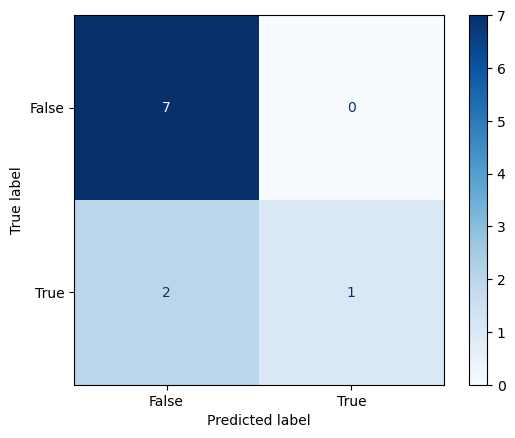

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Predicciones en test
y_pred = modelo_log.predict(X_test)

# Asertividad (Accuracy)
acc = accuracy_score(y_test, y_pred)
print(f"Asertividad en test: {acc:.3f}")

# Matriz de confusión (conteos absolutos)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_log.classes_)
disp.plot(cmap="Blues")

### 📌 Significado de cada celda del Gráfico - Matriz de Confusión

- TN (True Negative) = 7
El modelo acertó diciendo "No Beca" en 7 casos donde efectivamente no había beca.

- FP (False Positive) = 0
No hubo casos donde el modelo haya dicho "Sí Beca" pero en realidad no correspondía.

- FN (False Negative) = 2
El modelo dijo "No Beca" en 2 casos donde sí correspondía beca.
**⚠️ Esto significa que negó el beneficio a 2 alumnos que sí lo merecían.**

- TP (True Positive) = 1
El modelo acertó en 1 caso diciendo "Sí Beca" y efectivamente correspondía.

**Métricas adicionales**

- **classification_report**: precisión, recall y F1 por clase.
- **ROC AUC**: capacidad discriminativa usando probabilidades.

In [16]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred, target_names=["No Beca", "Sí Beca"]))

# Probabilidades para clase positiva (Sí Beca)
y_prob = modelo_log.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC: {auc:.3f}")

              precision    recall  f1-score   support

     No Beca       0.78      1.00      0.88         7
     Sí Beca       1.00      0.33      0.50         3

    accuracy                           0.80        10
   macro avg       0.89      0.67      0.69        10
weighted avg       0.84      0.80      0.76        10

ROC AUC: 0.905


C:\Users\ffeli\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### **Paso 8:** Prueba del modelo de ML con nuevos datos

Acá haremos una prueba del modelo con datos de alumnos nuevos que no tienen becas asignadas.

In [18]:
import pandas as pd

nuevos_postulantes = pd.DataFrame([
    {
        "edad": 18,
        "puntaje_paes": 640,
        "promedio_notas": 5.6,
        "ingreso_familiar": 820000,
        "sexo": "F",
        "tipo_colegio": "subvencionado",
        "comuna": "La Florida"
    },
    {
        "edad": 19,
        "puntaje_paes": 705,
        "promedio_notas": 6.1,
        "ingreso_familiar": 930000,
        "sexo": "M",
        "tipo_colegio": "municipal",
        "comuna": "Puente Alto"
    },
    {
        "edad": 18,
        "puntaje_paes": 610,
        "promedio_notas": 5.2,
        "ingreso_familiar": 780000,
        "sexo": "F",
        "tipo_colegio": "particular",
        "comuna": "Ñuñoa"
    },
    {
        "edad": 17,
        "puntaje_paes": 680,
        "promedio_notas": 5.8,
        "ingreso_familiar": 890000,
        "sexo": "M",
        "tipo_colegio": "subvencionado",
        "comuna": "Maipú"
    }
])

nuevos_postulantes.head()

,edad,puntaje_paes,promedio_notas,ingreso_familiar,sexo,tipo_colegio,comuna
0,18,640,5.6,820000,F,subvencionado,La Florida
1,19,705,6.1,930000,M,municipal,Puente Alto
2,18,610,5.2,780000,F,particular,Ñuñoa
3,17,680,5.8,890000,M,subvencionado,Maipú


In [19]:
# Predicción de clases (True/False)
pred_clase = modelo_log.predict(nuevos_postulantes)

# Probabilidad de clase positiva (Sí Beca = 1)
pred_proba = modelo_log.predict_proba(nuevos_postulantes)[:, 1]

# Resultado consolidado
resultado_nuevos = nuevos_postulantes.copy()
resultado_nuevos["prediccion_beca"] = pred_clase
resultado_nuevos["prob_sí_beca"] = pred_proba.round(3)

resultado_nuevos

,edad,puntaje_paes,promedio_notas,ingreso_familiar,sexo,tipo_colegio,comuna,prediccion_beca,prob_sí_beca
0,18,640,5.6,820000,F,subvencionado,La Florida,False,0.157
1,19,705,6.1,930000,M,municipal,Puente Alto,False,0.257
2,18,610,5.2,780000,F,particular,Ñuñoa,False,0.048
3,17,680,5.8,890000,M,subvencionado,Maipú,False,0.251


- `prediccion_beca`: `True` si el modelo clasifica como **Sí Beca**, `False` si **No Beca**.
- `prob_sí_beca`: qué tan seguro está el modelo de asignar beca (umbral por defecto = 0.5).